In [76]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu ## for those wonderful p-values!

## Nature journal settings
plt.rcParams["font.family"] = "Arial"
colors = ["#E64B35FF", "#3C5488FF", "#00A087FF", "#4DBBD5FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
sns.set_palette(sns.color_palette(colors))

In [77]:
fn = "pdx_expt/analysis/predictions.csv"
df = pd.read_csv(fn)
df.head()

,seed,sample_id,drug_id,transfer_pred,raw_pred
0,0,0,0,44.184930,0.7519
1,0,0,1,44.157024,1.7782
2,0,0,2,44.212124,1.7782
3,0,0,3,44.198357,0.6381
4,0,0,4,44.144733,0.2441


In [78]:
ground_truth_fn = "~/Documents/research/drug-response-repo/drug-response/pyro_model/data/yaspo_combined.csv"
gt = pd.read_csv(ground_truth_fn)
gt.head()

,patient_id,pdo,drug,log10_ic50_(uM),pdo_response_category,pdx,T_C,pdx_response_category,drug_id,sample_id
0,155_T,155_T_XEN_CELL,AZD8931,0.7519,Resistant,155_T_XEN,53.0,Resistant,0,0
1,155_T,155_T_XEN_CELL,5-FU,1.7782,Resistant,155_T_XEN,47.0,Minor response,1,0
2,155_T,155_T_XEN_CELL,oxaliplatin,1.7782,Resistant,155_T_XEN,53.0,Resistant,2,0
3,155_T,155_T_XEN_CELL,regorafenib,0.6381,Minor response,155_T_XEN,44.0,Minor response,3,0
4,155_T,155_T_XEN_CELL,afatinib,0.2441,Minor response,155_T_XEN,79.0,Resistant,4,0


In [79]:
gt_cols = ['sample_id', 'drug_id', 'pdx_response_category']
df = df.merge(gt[gt_cols], on=['sample_id', 'drug_id'], validate='one_to_one')
df['label'] = df['pdx_response_category'].isin(['Strong response', 'Moderate response']).astype(int)
df.head()

,seed,sample_id,drug_id,transfer_pred,raw_pred,pdx_response_category,label
0,0,0,0,44.184930,0.7519,Resistant,0
1,0,0,1,44.157024,1.7782,Minor response,0
2,0,0,2,44.212124,1.7782,Resistant,0
3,0,0,3,44.198357,0.6381,Minor response,0
4,0,0,4,44.144733,0.2441,Resistant,0


In [80]:
# raw prediction is just the log10_ic50 value!
# pdx response category is ground truth

In [81]:
df = df.loc[df.sample_id == 11]

In [82]:
from tqdm import trange

# scores are transfer predictions, labels are the ground-truth from pdx response categories
scores = df.transfer_pred.to_numpy()
labels = df.label.to_numpy()

# ROC curve
def calc_tpr_fpr(labels, scores):
    order = np.argsort(scores)[::-1]
    tpr = labels[order].cumsum() / labels.sum() # AKA recall
    precision = labels[order].cumsum() / np.arange(1,labels.shape[0]+1)
    fpr = (~labels[order]).cumsum() / (~labels).sum()
    return tpr, fpr

tpr, fpr = calc_tpr_fpr(labels, scores)
auc = np.trapz(tpr, fpr)
print(auc)

# Calculate the p-value via a permutation test
np.random.seed(100)
def perm_test(labels, scores, n_trials=100000):
    labels = np.copy(labels)
    n_succ = 0
    for trial in trange(n_trials):
        np.random.shuffle(labels)
        null_tpr, null_fpr = calc_tpr_fpr(labels, scores)
        null_auc = np.trapz(null_tpr, null_fpr)
        if null_auc >= auc:
            n_succ += 1
    return n_succ / n_trials

p_value = perm_test(labels, scores)
print(p_value)

n_pos = np.sum(labels)
n_neg = len(labels) - n_pos

0.5


100%|████████████████████████████████| 100000/100000 [00:02<00:00, 35913.99it/s]

0.52636


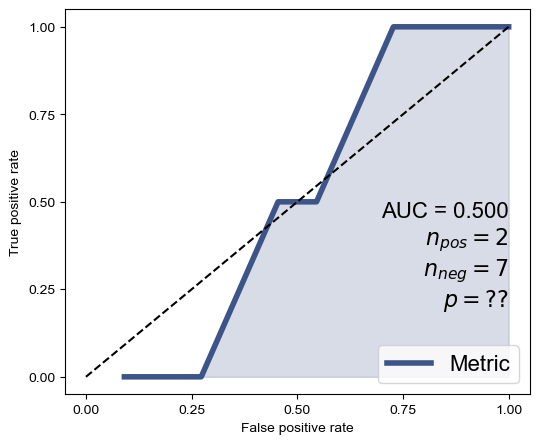

In [83]:
# Plot and label the ROC curve
fig, ax = plt.subplots(figsize=(6,5))
plt.plot(fpr, tpr, label='Metric', color=colors[1], linewidth=4)
plt.text(1, 0.2, f'AUC = {auc:.3f}\n $n_{{pos}} = {n_pos}$\n $n_{{neg}} = {n_neg}$\n$p = ??$', ha='right', fontsize=16)
plt.plot([0,1], [0,1], ls='--', color='black')
plt.xticks([0,0.25, 0.5, 0.75, 1])
plt.yticks([0,0.25, 0.5, 0.75, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', fontsize=16)
plt.fill_between(fpr,tpr, color=colors[1], alpha=0.2)
#plt.savefig("plots/auc.png", bbox_inches='tight')